In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import itertools
import numpy as np
import torch as tr
import pandas as pd
from matplotlib import pyplot as plt

from CSWSEM import *

gs_name = 'pdim1'

In [3]:
DEBUG=1
if DEBUG:
  NTRAIN=40
  NTEST=2
  CONDL=['single','interleaved']
else:
  NTRAIN=160
  NTEST=40
  CONDL=['blocked','interleaved']


In [4]:
def run_batch_exp(num_seeds,sem_kwargs,exp_kwargs):
  """ wrap wround seeds for single paramconfig
  """
  batch_dataL = []
  for seed in range(num_seeds):
    print('seed',seed)
    sem_kwargs['seed'] = seed
    # run
    sem = SEM(**sem_kwargs)
    task = CSWTask()
    exp,curr = task.generate_experiment(**exp_kwargs)
    sem_data = sem.forward_exp(exp,curr)
    # record
    sem.data.record_exp('condition',exp_kwargs['condition'])
    # collect
    sem_data_df = pd.DataFrame(sem_data,dtype='float64')
    batch_dataL.append(sem_data_df)
  return pd.concat(batch_dataL)

def run_BIexp(num_seeds,sem_kwargs,ntrain=NTRAIN,ntest=NTEST):
  """ wrap around task conditions
  """
  exp_dataL = []
  exp_kwargs = {'n_train':ntrain,'n_test':ntest}
  for cond in CONDL:
    exp_kwargs['condition'] = cond
    batch_data = run_batch_exp(num_seeds,sem_kwargs,exp_kwargs)
    exp_dataL.append(batch_data)
  return pd.concat(exp_dataL)

In [5]:
sem_kwargs={
  'nosplit':0,
  'alfa':10000000,
  'lmda':0.1,
  'seed':np.random.randint(99),
  'stsize':15,
  'learn_rate':0.05
}

In [6]:
## GRIDSEARCH

# n1 = 'alfa'
# L1 = [1,100,100000]
# n2 = 'lmda'
# L2 = [.1,.001,.0001]
n1 = 'stsize'
L1 = [12,15,17]
n2 = 'learn_rate'
L2 = [0.04,0.05,0.06]
num_seeds = 10

gsdataL = []
for idx,(v1,v2) in enumerate(itertools.product(L1,L2)):
  print(v1,v2)
  sem_kwargs[n1] = v1
  sem_kwargs[n2] = v2
  exp_data = run_BIexp(num_seeds,sem_kwargs)
  gsdataL.append(exp_data)
    
gsdata = pd.concat(gsdataL)
gsdata = gsdata.groupby(['condition','trial',n1,n2]).mean().reset_index()

12 0.04
seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9
seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9
12 0.05
seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9
seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9
12 0.06
seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9
seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9
15 0.04
seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9
seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9
15 0.05
seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9
seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9
15 0.06
seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9
seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9
17 0.04
seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9
seed 0
seed 1
seed 2
seed 3
seed 4

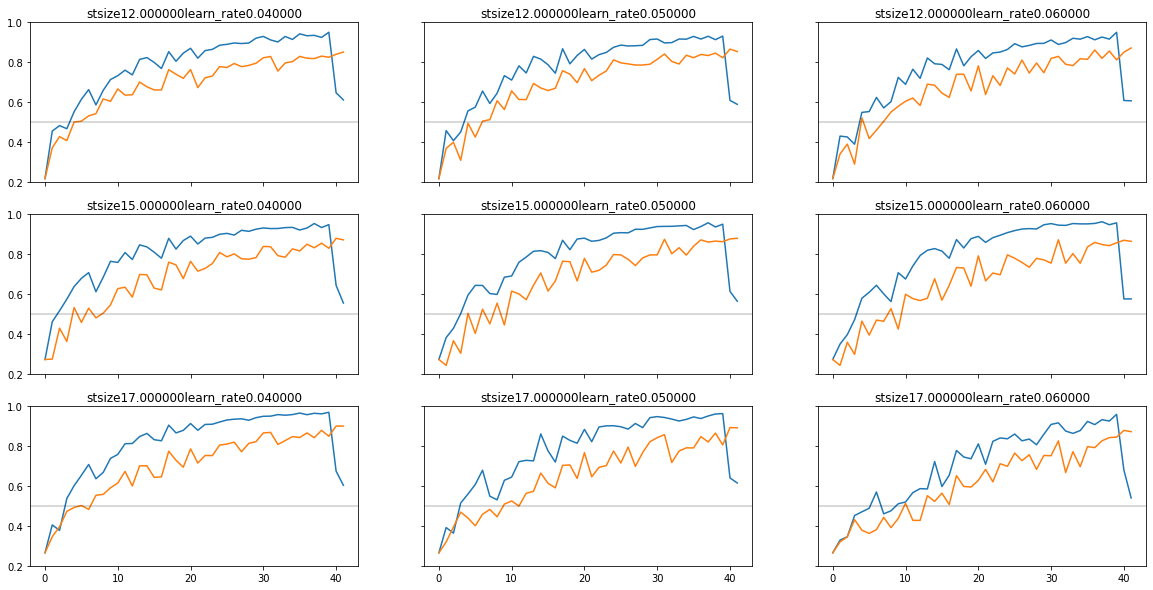

In [7]:
## PLT GRIDSEARCH
f,axar = plt.subplots(3,3,figsize=(20,10),sharey=True,sharex=True);axar=axar.reshape(-1)

for idx,(v1_,v2_) in enumerate(itertools.product(L1,L2)):
  ax = axar[idx]
  for c in CONDL:
    cdata = gsdata[(
      gsdata.condition==c)&(
      gsdata.loc[:,n1]==v1_)&(
      gsdata.loc[:,n2]==v2_)
    ]
    acc = 1-cdata.loss
    ax.plot(np.arange(len(acc)),acc)
  ax.set_title('%s%f%s%f'%(n1,v1_,n2,v2_))
  ax.set_ylim(0.2,1)
  ax.axhline(0.5,c='k',lw=.3)
plt.savefig('figures/gs-%s&%s'%(n1,n2))